In [18]:
#!pip install sympy
#!pip install control
#!pip install tbcontrol
#!pip install ipywidgets
#!pip install perlin_noise
#!pip install numpy
#!pip install matplotlib ipympl jupyter

In [19]:
import numpy as np
import scipy.linalg as la
import matplotlib.pyplot as plt
%matplotlib widget
import control as ct
import sympy as sp

import ipywidgets as widgets
from ipywidgets import interactive

from scipy.interpolate import interp1d
from perlin_noise import PerlinNoise
from scipy.optimize import minimize
from tbcontrol.symbolic import routh
from sympy.solvers import solve

s = ct.tf([1, 0], [1])

In [20]:
# Paleta de cores do prof. Renato:
cp = {
    'red': (1.0, 0.349, 0.369, 1.0),
    'green': (0.541, 0.788, 0.149, 1.0),
    'blue': (0.098, 0.510, 0.769, 1.0),
    'lred': (1.0, 0.588, 0.6, 1.0),
    'lgreen': (0.722, 0.894, 0.443, 1.0),
    'lblue': (0.369, 0.706, 0.918, 1.0),
    'dred': (0.839,0.0,0.027),
    'dgreen': (0.341,0.494,0.094),
    'dblue': (0.063,0.318,0.475),
    'orange': (1.0, 0.506, 0.227, 1.0),
    'yellow': (1.0, 0.792, 0.227, 1.0),
    'pink': (1.0, 0.349, 0.611, 1.0),
    'purple': (0.416, 0.298, 0.576, 1.0),
    'turquoise': (0.098, 0.761, 0.769, 1.0),
    'brown': (0.576, 0.380, 0.298, 1.0)
}

In [21]:
#Parâmetros (Towsend & Shenoi):
I44 = 430.9e3 #[kg.m²]
A44 = 129.3e3 #[kg.m²]
B44 = 225.1e3 #[kg.m²/s]
C44 = 2262.2e3 #[kg.m²/s²]
Is = 54.8 #[kg.m²]
It = 47.2 #[kg.m²]
Bg = 2500 #[kg.m²/s]
Cg = 5000 #[kg.m²/s²]

# Representação em Espaço de Estados

In [22]:
#Definição das matrizes do modelo SLIT:
Ω = sp.symbols('Ω')

A = sp.Matrix([[0,0,1,0],[0,0,0,1],[-(C44/(I44 + A44)), 0, -(B44/(I44 + A44)), -(2*Is*Ω/(I44 + A44))],[0, -Cg/It, Is*Ω/It, -Bg/It]])
B = sp.Matrix([[0],[0],[0],[1/It]])
E = sp.Matrix([[0],[0],[1/(I44 + A44)],[0]])

C_φ = sp.Matrix([[1,0,0,0]])

In [23]:
An = sp.lambdify((Ω), A)
Bn = sp.lambdify((), B)
En = sp.lambdify((), E)

In [24]:
#Valor de Ω = 10000 rpm constante:
boat_ss = ct.ss(An(10000*np.pi/30), B, C_φ, 0)
boat_ss

<LinearIOSystem:sys[63]:['u[0]']->['y[0]']>

### Função de transferência da planta

In [25]:
G_p0 = ct.tf(boat_ss)

# elimina, se aparecer, um termo efetivamente nulo (< 1e-10 * s^3) no numerador
if (np.abs(G_p0.num[0][0][0]) < 1e-10):
    G_p = ct.tf(G_p0.num[0][0][2:], G_p0.den[0][0])
else:
    G_p = G_p0
G_p

TransferFunction(array([-4.34064301e-03,  3.97903932e-13]), array([  1.        ,  53.36792247, 380.34727207, 256.45350631,
       427.7754918 ]))

In [26]:
G_p.zeros()

array([9.16693521e-11+0.j])

In [27]:
zeros = G_p.zeros()
poles = G_p.poles()
N = (0.004341)*ct.tf(np.poly(zeros),[1])
D = ct.tf(np.poly(poles),[1])
L_0 = N/D
L_0

TransferFunction(array([ 4.34100000e-03, -3.97936657e-13]), array([  1.        ,  53.36792247, 380.34727207, 256.45350631,
       427.7754918 ]))

In [28]:
L_0.zeros()

array([9.16693521e-11+0.j])

### Determinação dos Ganhos Críticos

In [29]:
s_s = sp.symbols('s')
N_s = (0.004341)*sp.Poly(np.poly(zeros), s_s)
D_s = sp.Poly(np.poly(poles), s_s)
N_s/D_s

(0.004341*s - 3.97936657329827e-13)/(1.0*s**4 + 53.3679224732088*s**3 + 380.347272065259*s**2 + 256.453506314331*s + 427.775491803777)

In [30]:
K_c = sp.symbols('K_c')
B_s = K_c * N_s + D_s

table_B = routh(B_s)
table_B

Matrix([
[                                                                                                                                                                         1.0,                            380.347272065259, 427.775491803777 - 3.97936657329827e-13*K_c],
[                                                                                                                                                            53.3679224732088,             0.004341*K_c + 256.453506314331,                                           0],
[                                                                                                                                  375.541885337997 - 8.13409965917114e-5*K_c, 427.775491803777 - 3.97936657329827e-13*K_c,                                           0],
[                                                          (3.53101266204619e-7*K_c**2 - 1.60936714049043*K_c - 73479.543980301)/(8.13409965917114e-5*K_c - 375.541885337997),                   

In [31]:
sp.solve(table_B[2, 0] > 0, K_c)

(-oo < K_c) & (K_c < 4616883.25781177)

In [32]:
sp.solve(table_B[3, 0] > 0, K_c)

((-45208.9863541625 < K_c) & (K_c < 4603015.18679361)) | ((4616883.25781177 < K_c) & (K_c < oo))

De fato, a planta é *condicionalmente estável*, ou seja, é possível ter um comportamento estável em malha fechada com controlador *proporcional* ($K_c$) se, e somente se: $$-45208.42 < K_c < 4616883.65$$

# Síntese de um compensador PD via Lugar das Raízes

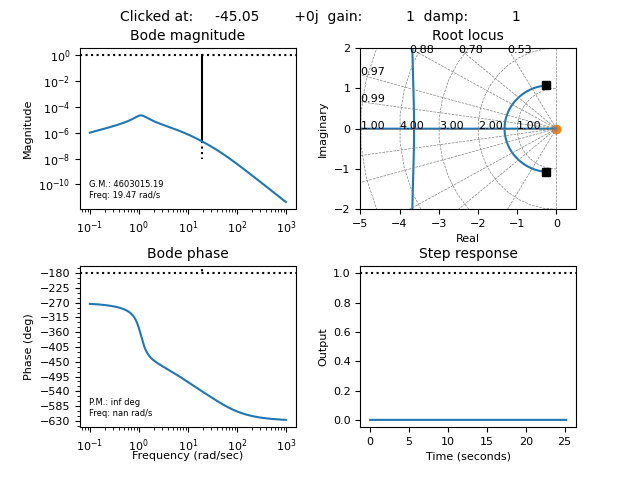

In [33]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_0, xlim_rlocus=(-5, 0.5), ylim_rlocus=(-2, 2),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

A partir do lugar das raízes $L(s)$, pode-se escolher como valor inicial para o ganho proporcional $K_p = 2275.0$.

Podemos agora trocar o controlador *proporcional* (P) por um *proporcional-derivativo* (PD), de tal forma que a nova FTMA se torna:
\begin{align*}
    L_{\text{PD}}(s) = \left( K_p + K_d s \right) \frac{N(s)}{D(s)}
\end{align*}
Assim, as novas raízes em malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PD}}(s) = 0 
    \\
    & 1 + K_p \frac{N(s)}{D(s)} + \frac{K_d s N(s)}{D(s)} = 0
    \\ 
    & D(s) + K_p N(s) + K_d s N(s) = 0
    \\ 
    & 1 +  K_d \underbrace{\frac{s N(s)}{D(s) + K_p N(s)}}_{\displaystyle L_5(s)} = 0
\end{align*}

In [34]:
K_p = 33000

In [35]:
L_5 = (s * N)/(D + K_p * N)
L_5

TransferFunction(array([ 4.34100000e-03, -3.97936657e-13,  0.00000000e+00]), array([  1.        ,  53.36792247, 380.34727207, 399.70650631,
       427.77549179]))

Lugar das raízes de $L_5(s)$ e ajuste de $K_d$

KeyboardInterrupt: 

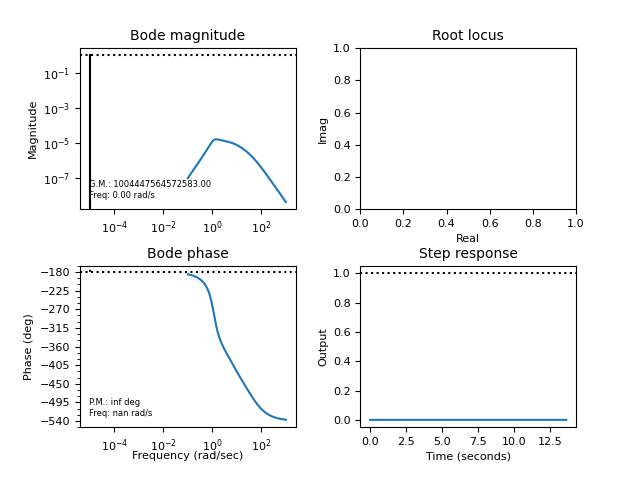

In [36]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_5, xlim_rlocus=(-1, 0.5), ylim_rlocus=(-2, 2),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa


A partir da análise do lugar das raízes para $L_5(s)$, chega-se a $K_d = 1 \ \text{s}$ como escolha razoável para o ganho derivativo.

Assim pode-se calcular $T_d$ pelas expressão:
$$T_d = \frac{K_d}{K_p}$$

In [ ]:
K_d = 300.0
T_d = K_d/K_p
T_d

0.00909090909090909

Finalmente, assumindo os valor calculado para $T_d$, pode-se fazer um ajuste fino para $K_c$:
\begin{align*}
    L_{\text{PD}}(s) = K_c \left(1 + T_d s \right) \frac{N(s)}{D(s)}
\end{align*}
As raízes de malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PD}}(s) = 0 
    \\
    & 1 +  K_c \underbrace{\frac{\left(1 + T_d s \right) N(s)}{D(s)}}_{\displaystyle L_6(s)} = 0
\end{align*}

In [ ]:
L_6 = ((1 + T_d * s) * N)/D
L_6

TransferFunction(array([ 3.94636364e-05,  4.34100000e-03, -3.97936657e-13]), array([  1.        ,  53.36792247, 380.34727207, 256.45350631,
       427.7754918 ]))

Lugar das raízes de $L_6(s)$ e ajuste fino de $K_c$

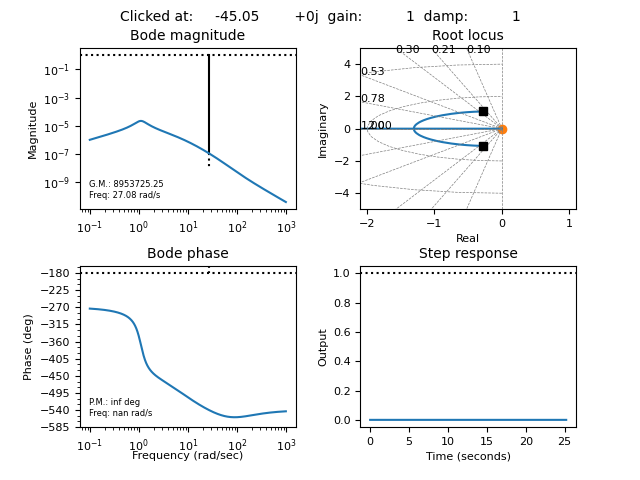

Clicked at    -0.5145    +1.083j gain  3.211e+04 damp      0.429
Clicked at    -0.4551    +1.207j gain  2.254e+04 damp     0.3527
Clicked at    -0.4551    +1.207j gain  2.254e+04 damp     0.3527
Clicked at     -0.559   +0.9594j gain    4.2e+04 damp     0.5034
Clicked at    -0.4551    +1.269j gain    2.2e+04 damp     0.3375
Clicked at    -0.4551    +1.269j gain    2.2e+04 damp     0.3375
Clicked at    -0.6591   +0.9182j gain  5.459e+04 damp     0.5831
Clicked at    -0.6591   +0.9182j gain  5.459e+04 damp     0.5831
Clicked at    -0.6591   +0.9182j gain  5.459e+04 damp     0.5831
Clicked at    -0.5656    +1.086j gain  3.791e+04 damp     0.4619
Clicked at    -0.5656    +1.086j gain  3.791e+04 damp     0.4619
Clicked at    -0.4988    +1.086j gain  3.018e+04 damp     0.4174


In [ ]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_6, xlim_rlocus=(-2.1, 1.1), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

Assim, adotando $K_c$ = 400, tem-se o seguinte compensador PD:

In [ ]:
K_c_PD = 33000
N_d = 1000

G_c_PD = K_c_PD * (1 + (T_d * s)/(1 + T_d * s/N_d))
G_c_PD

TransferFunction(array([  300300., 33000000.]), array([9.09090909e-03, 1.00000000e+03]))

Diagrama de Bode do compensador PD sintetizado

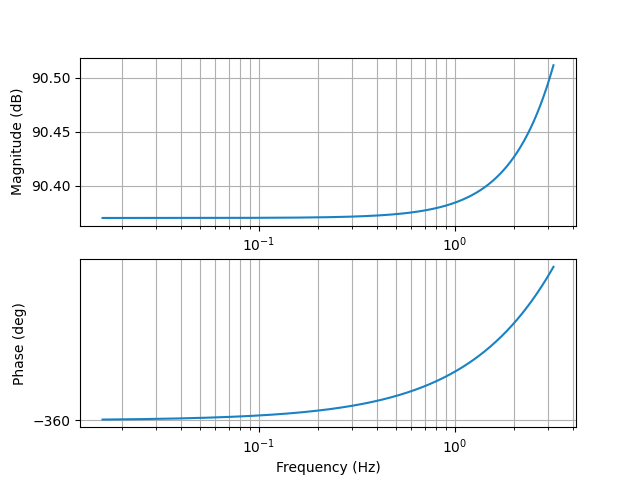

In [ ]:
plt.figure()
G_c_M, G_c_φ, G_c_ω = ct.bode_plot(G_c_PD,
                                   omega=np.linspace(0.1, 20, 1001),
                                   color=cp['blue'],
                                   dB=True, Hz=True)

# Síntese de Compensadores PI e PID via Lugar das Raízes

Tomaremos o mesmo valor inicial presumido de $K_p$ = 475.0

In [ ]:
K_p = 33000.0
L_1 = N/(s * (D + K_p * N))
L_1

TransferFunction(array([ 4.34100000e-03, -3.97936657e-13]), array([  1.        ,  53.36792247, 380.34727207, 399.70650631,
       427.77549179,   0.        ]))

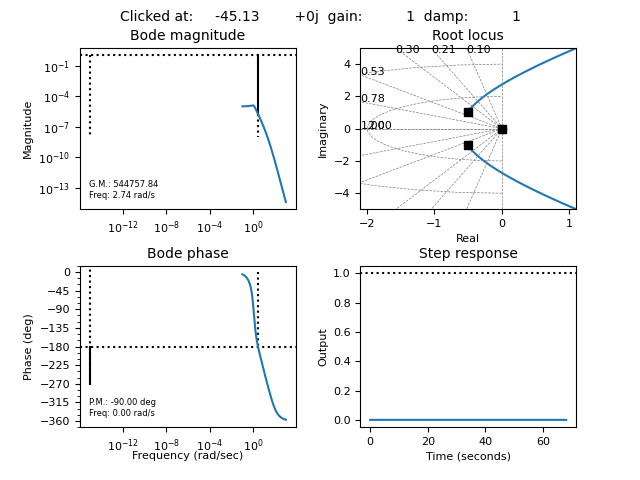

Clicked at    -0.4403    +1.393j gain  6.425e+04 damp     0.3013
Clicked at    -0.4699    +1.269j gain  3.976e+04 damp     0.3472
Clicked at    -0.3512    +1.703j gain  1.386e+05 damp      0.202
Clicked at    -0.4699    +1.331j gain  5.101e+04 damp     0.3329
Clicked at    -0.4699    +1.331j gain  5.101e+04 damp     0.3329


In [ ]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_1, xlim_rlocus=(-2.1, 1.1), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

A partir da análise do lugar das raízes para $L_1(s)$, chega-se a $K_i = 3.0 \ \text{s}^{-1}$ como escolha razoável para o ganho integral.

Assim pode-se calcular $T_i$ pela expressão:
$$T_i = \frac{K_p}{K_i}$$

In [ ]:
K_i = 3000
T_i = K_p/K_i
T_i

11.0

Assumindo os valor calculados para $T_i$, pode-se fazer um ajuste fino para $K_c$:
\begin{align*}
    L_{\text{PI}}(s) = K_c \left(1 + \frac{1}{T_i s}\right) \frac{N(s)}{D(s)}
\end{align*}
As raízes de malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PI}}(s) = 0 
    \\
    & 1 +  K_c \left(1 + \frac{1}{T_i s} \right) \frac{N(s)}{D(s)} = 0
    \\
    & 1 +  K_c \underbrace{\frac{(1 + T_i s)N(s)}{s T_i D(s)}}_{\displaystyle L_2(s)} = 0
\end{align*}

In [ ]:
L_2 = (1 + T_i * s) * N/(s * T_i * D)
L_2

TransferFunction(array([ 4.77510000e-02,  4.34100000e-03, -3.97936657e-13]), array([  11.        ,  587.04714721, 4183.81999272, 2820.98856946,
       4705.53040984,    0.        ]))

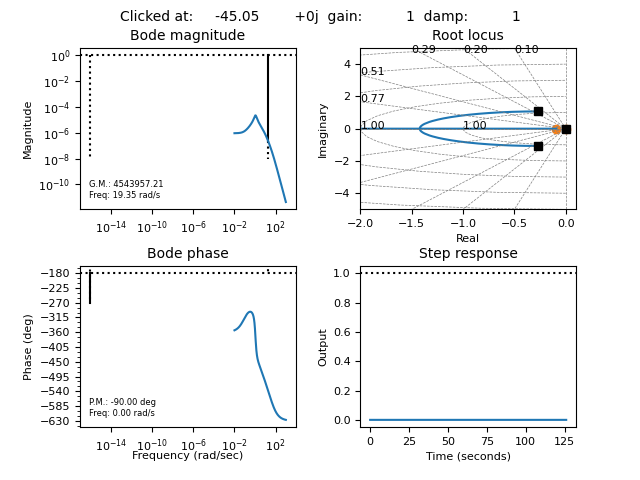

Clicked at    -0.6576   +0.9594j gain  5.416e+04 damp     0.5654
Clicked at    -0.6576   +0.9594j gain  5.416e+04 damp     0.5654
Clicked at    -0.6576   +0.9594j gain  5.416e+04 damp     0.5654
Clicked at    -0.6089    +1.083j gain   4.46e+04 damp       0.49
Clicked at    -0.6089    +1.083j gain   4.46e+04 damp       0.49
Clicked at    -0.5213    +1.021j gain  3.589e+04 damp     0.4546
Clicked at    -0.4142    +1.083j gain  2.034e+04 damp     0.3571
Clicked at    -0.4142    +1.083j gain  2.034e+04 damp     0.3571
Clicked at    -0.4726    +1.083j gain  2.813e+04 damp     0.3998
Clicked at    -0.4726    +1.083j gain  2.813e+04 damp     0.3998
Clicked at    -0.4726    +1.083j gain  2.813e+04 damp     0.3998
Clicked at    -0.4726    +1.083j gain  2.813e+04 damp     0.3998
Clicked at     -0.531    +1.083j gain  3.549e+04 damp     0.4401


In [ ]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_2, xlim_rlocus=(-2, 0.1), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

Obtém-se assim $K_c = 410$, o que leva o seguinte compensador PI:

In [ ]:
K_c_PI = 35000

G_c_PI = K_c_PI * (1 + 1/(T_i * s))
G_c_PI

TransferFunction(array([385000.,  35000.]), array([11.,  0.]))

Diagrama de Bode do compensador PI sintetizado

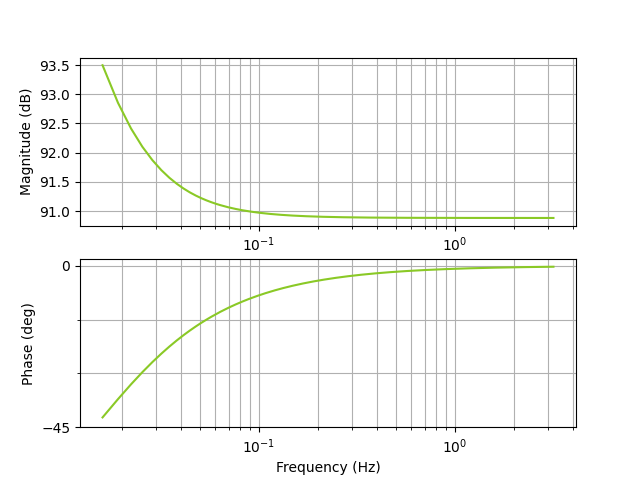

In [ ]:
plt.figure()
G_c_M, G_c_φ, G_c_ω = ct.bode_plot(G_c_PI,
                                   omega=np.linspace(0.1, 20, 1001),
                                   color=cp['green'],
                                   dB=True, Hz=True)

#### 3.3. Síntese de um compensador PID

Podemos agora trocar o controlador *proporcional-integral* (PI) por um *proporcional-integral-derivativo* (PID), de tal forma que a nova FTMA se torna:
\begin{align*}
    L_{\text{PID}}(s) = \left( K_p + \frac{K_i}{s} + K_d s \right) \frac{N(s)}{D(s)}
\end{align*}
Assim, as novas raízes em malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PID}}(s) = 0 
    \\
    & 1 + K_p \frac{N(s)}{D(s)} + K_i \frac{N(s)}{s D(s)} + \frac{K_d s N(s)}{D(s)} = 0
    \\ 
    & s D(s) + (K_p s + K_i)N(s) + K_d s^2 N(s) = 0
    \\ 
    & 1 +  K_d \underbrace{\frac{s^2 N(s)}{s D(s) + (K_p s + K_i)N(s)}}_{\displaystyle L_3(s)} = 0
\end{align*}

In [ ]:
L_3 = (s * s * N)/(s * D + (K_p * s + K_i) * N)
L_3

TransferFunction(array([ 4.34100000e-03, -3.97936657e-13,  0.00000000e+00,  0.00000000e+00]), array([ 1.00000000e+00,  5.33679225e+01,  3.80347272e+02,  3.99706506e+02,
        4.40798492e+02, -1.19380997e-09]))

Lugar das raízes de $L_3(s)$ e ajuste de $K_d$

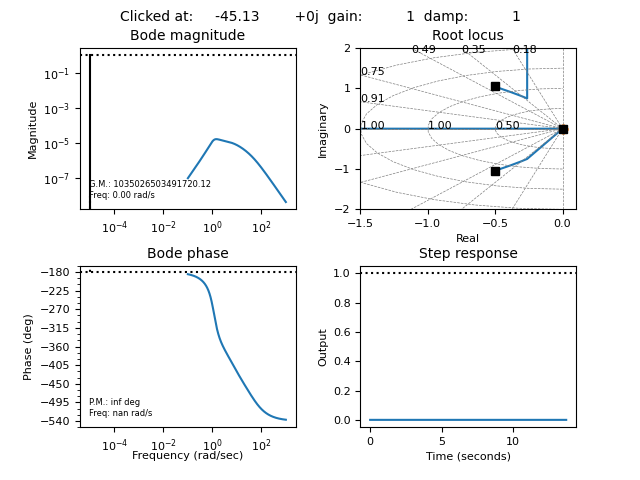

Clicked at    -0.4179   +0.9787j gain  1.369e+04 damp     0.3927
Clicked at    -0.4179   +0.9787j gain  1.369e+04 damp     0.3927
Clicked at    -0.3659   +0.9291j gain  2.532e+04 damp     0.3664
Clicked at    -0.3659   +0.9291j gain  2.532e+04 damp     0.3664
Clicked at    -0.2917   +0.8052j gain  5.904e+04 damp     0.3407
Clicked at    -0.2917   +0.8052j gain  5.904e+04 damp     0.3407
Clicked at    -0.4401   +0.9291j gain  1.714e+04 damp     0.4281
Clicked at    -0.4401   +0.9291j gain  1.714e+04 damp     0.4281
Clicked at    -0.3808   +0.9043j gain  2.733e+04 damp     0.3881
Clicked at    -0.3808   +0.9043j gain  2.733e+04 damp     0.3881


In [ ]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_3, xlim_rlocus=(-1.5, 0.1), ylim_rlocus=(-2, 2),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

A partir da análise do lugar das raízes para $L_3(s)$, chega-se a $K_d = 1 \ \text{s}$ como escolha razoável para o ganho derivativo.

Assim pode-se calcular $T_d$ pelas expressão:
$$T_d = \frac{K_d}{K_p}$$

In [ ]:
K_d = 9500.0
T_d = K_d/K_p
T_d

0.2878787878787879

Finalmente, assumindo os valores calculados para $T_i$ e $T_d$, pode-se fazer um ajuste fino para $K_c$:
\begin{align*}
    L_{\text{PID}}(s) = K_c \left(1 + \frac{1}{T_i s} + T_d s \right) \frac{N(s)}{D(s)}
\end{align*}
As raízes de malha fechada serão dadas por:
\begin{align*}
    & 1 + L_{\text{PID}}(s) = 0 
    \\
    & 1 +  K_c \left(1 + \frac{1}{T_i s} + T_d s \right) \frac{N(s)}{D(s)} = 0
    \\
    & 1 +  K_c \underbrace{\frac{(1 + T_i s + T_d T_i s^2)N(s)}{s T_i D(s)}}_{\displaystyle L_4(s)} = 0
\end{align*}


In [ ]:
L_4 = ((1 + T_i * s + T_d * T_i * s * s) * N)/(s * T_i * D)
L_4

TransferFunction(array([ 1.37465000e-02,  4.77510000e-02,  4.34100000e-03, -3.97936657e-13]), array([  11.        ,  587.04714721, 4183.81999272, 2820.98856946,
       4705.53040984,    0.        ]))

Lugar das raízes de $L_4(s)$ e ajuste fino de $K_c$

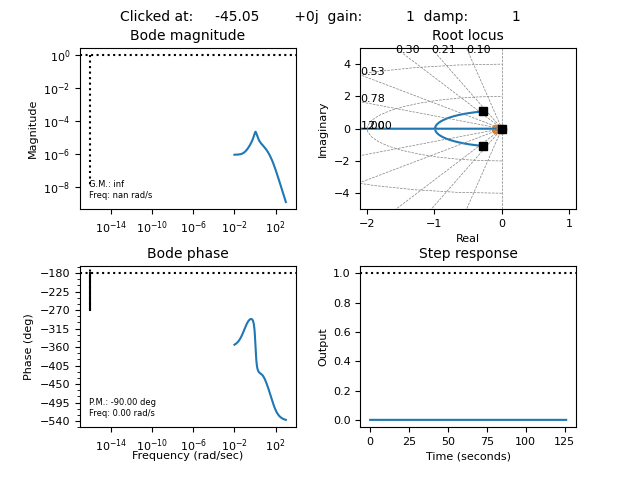

Clicked at    -0.5293   +0.8975j gain  5.307e+04 damp      0.508
Clicked at    -0.4551    +1.083j gain  2.564e+04 damp     0.3873
Clicked at    -0.7815   +0.7735j gain  9.947e+04 damp     0.7107
Clicked at    -0.4551   +0.8975j gain  4.184e+04 damp     0.4523
Clicked at    -0.5145   +0.9594j gain  4.462e+04 damp     0.4726
Clicked at    -0.5145    +1.021j gain  3.889e+04 damp     0.4498
Clicked at    -0.4551    +1.083j gain  2.564e+04 damp     0.3873
Clicked at    -0.4551    +1.083j gain  2.564e+04 damp     0.3873
Clicked at    -0.4848    +1.083j gain  2.967e+04 damp     0.4084
Clicked at    -0.4848    +1.083j gain  2.967e+04 damp     0.4084
Clicked at    -0.5441    +1.083j gain  3.749e+04 damp     0.4488
Clicked at    -0.4996    +1.083j gain  3.166e+04 damp     0.4188
Clicked at    -0.4996    +1.083j gain  3.166e+04 damp     0.4188
Clicked at    -0.4996    +1.083j gain  3.166e+04 damp     0.4188


In [ ]:
plt.ion()  # ativar o modo interativo
ct.sisotool(L_4, xlim_rlocus=(-2.1, 1.1), ylim_rlocus=(-5, 5),
            rlocus_grid=True)  # ferramenta interativa SISO Design Tool
plt.draw()  # desenhar a janela interativa

Assim, adotando $K_c = 400$, tem-se o seguinte compensador PID:

In [ ]:
K_c_PID = 33000
N_d = 1000

G_c_PID = K_c_PID * (1 + 1/(T_i * s) + (T_d * s)/(1 + T_d * s/N_d))
G_c_PID

TransferFunction(array([1.046045e+08, 3.630095e+08, 3.300000e+07]), array([3.16666667e+00, 1.10000000e+04, 0.00000000e+00]))

Diagrama de Bode do compensador PID sintetizado

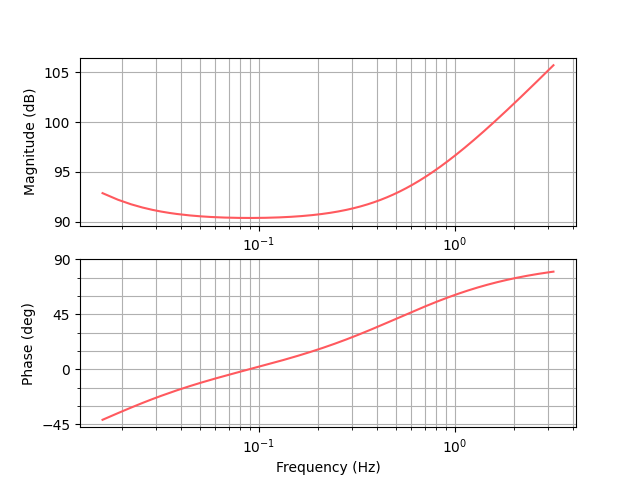

In [ ]:
plt.figure()
G_c_M, G_c_φ, G_c_ω = ct.bode_plot(G_c_PID,
                                omega=np.linspace(0.1, 20, 1001),
                                color=cp['red'],
                                dB=True, Hz=True)

### Análise das respostas em malha fechada com compensadores PI, PD e PID

#### Função de transferência entre referência (r) e saída (c)

In [ ]:
rc_tf_PI = ct.feedback(G_c_PI * L_0)
rc_tf_PD = ct.feedback(G_c_PD * L_0)
rc_tf_PID = ct.feedback(G_c_PID * L_0)
rc_tf_PID

TransferFunction(array([ 4.54088134e+05,  1.57582424e+06,  1.43253000e+05, -1.31319097e-05]), array([ 3.16666667e+00,  1.11689984e+04,  5.88251580e+05,  4.63872023e+06,
        4.39816743e+06,  4.84878341e+06, -1.31319097e-05]))

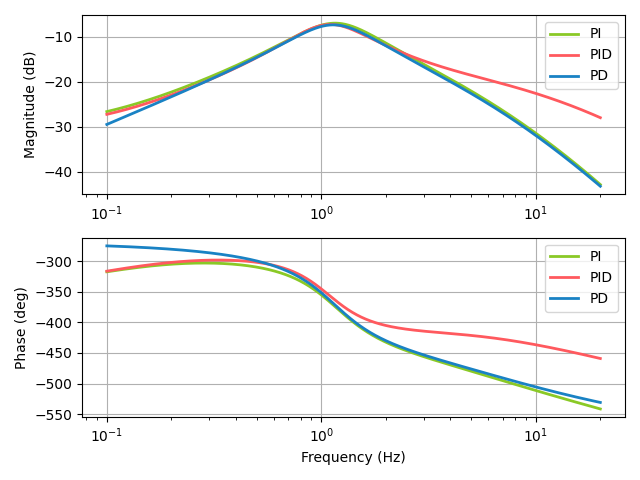

In [ ]:
plt.figure()
plt.subplot(2, 1, 1)

mag_PI, phase_PI, omega_PI = ct.bode(
    rc_tf_PI, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)
mag_PID, phase_PID, omega_PID = ct.bode(
    rc_tf_PID, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)
mag_PD, phase_PD, omega_PD = ct.bode(
    rc_tf_PD, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)


plt.semilogx(omega_PI, 20 * np.log10(mag_PI),
             label='PI', color=cp['green'], linewidth=2)
plt.semilogx(omega_PID, 20 * np.log10(mag_PID),
             label='PID', color=cp['red'], linewidth=2)
plt.semilogx(omega_PD, 20 * np.log10(mag_PD),
             label='PD', color=cp['blue'], linewidth=2)
plt.ylabel('Magnitude (dB)')

# plt.title('Magnitude')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.semilogx(omega_PI, phase_PI * (180.0 / np.pi),
             label='PI', color=cp['green'], linewidth=2)
plt.semilogx(omega_PID, phase_PID * (180.0 / np.pi),
             label='PID', color=cp['red'], linewidth=2)
plt.semilogx(omega_PD, phase_PD * (180.0 / np.pi),
             label='PD', color=cp['blue'], linewidth=2)
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (Hz)')
# plt.title('Phase')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

#### Função de transferência entre referência (r) e entrada de controle (u)

In [ ]:
ru_tf_PI = ct.feedback(G_c_PI, L_0)
ru_tf_PD = ct.feedback(G_c_PD, L_0)
ru_tf_PID = ct.feedback(G_c_PID, L_0)
ru_tf_PID

TransferFunction(array([1.04604500e+08, 5.94553435e+09, 5.91920991e+10, 1.66657005e+11,
       1.50393761e+11, 1.63749533e+11, 1.41165912e+10]), array([ 3.16666667e+00,  1.11689984e+04,  5.88251580e+05,  4.63872023e+06,
        4.39816743e+06,  4.84878341e+06, -1.31319097e-05]))

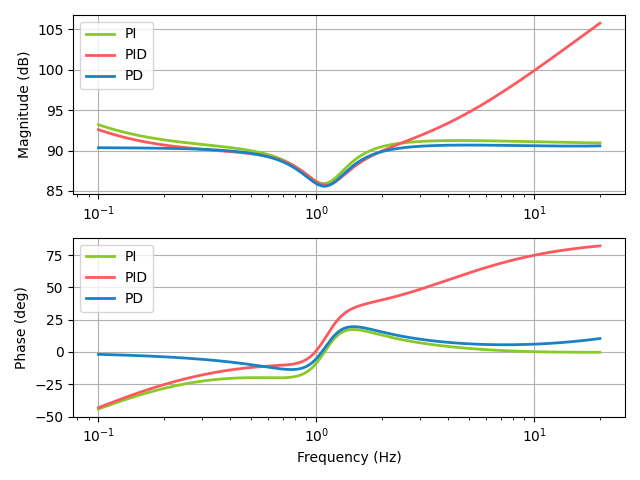

In [ ]:
plt.figure()
plt.subplot(2, 1, 1)

mag_PI, phase_PI, omega_PI = ct.bode(
    ru_tf_PI, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)
mag_PID, phase_PID, omega_PID = ct.bode(
    ru_tf_PID, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)
mag_PD, phase_PD, omega_PD = ct.bode(
    ru_tf_PD, dB=True, Hz=True, omega_limits=(0.1, 20), plot=False)


plt.semilogx(omega_PI, 20 * np.log10(mag_PI),
             label='PI', color=cp['green'], linewidth=2)
plt.semilogx(omega_PID, 20 * np.log10(mag_PID),
             label='PID', color=cp['red'], linewidth=2)
plt.semilogx(omega_PD, 20 * np.log10(mag_PD),
             label='PD', color=cp['blue'], linewidth=2)
plt.ylabel('Magnitude (dB)')

# plt.title('Magnitude')
plt.grid()
plt.legend()

plt.subplot(2, 1, 2)
plt.semilogx(omega_PI, phase_PI * (180.0 / np.pi),
             label='PI', color=cp['green'], linewidth=2)
plt.semilogx(omega_PID, phase_PID * (180.0 / np.pi),
             label='PID', color=cp['red'], linewidth=2)
plt.semilogx(omega_PD, phase_PD * (180.0 / np.pi),
             label='PD', color=cp['blue'], linewidth=2)
plt.ylabel('Phase (deg)')
plt.xlabel('Frequency (Hz)')
# plt.title('Phase')
plt.grid()
plt.legend()

plt.tight_layout()
plt.show()

#### Resposta a degrau

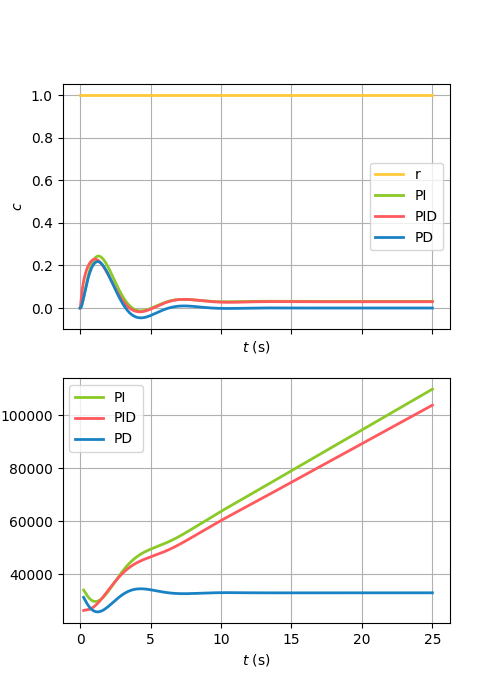

In [ ]:
# simulação do sistema em MF
ts = np.linspace(0, 25, 1000)

t, y_PI = ct.step_response(rc_tf_PI, ts)
t, u_PI = ct.step_response(ru_tf_PI, ts)

t, y_PID = ct.step_response(rc_tf_PID, ts)
t, u_PID = ct.step_response(ru_tf_PID, ts)

t, y_PD = ct.step_response(rc_tf_PD, ts)
t, u_PD = ct.step_response(ru_tf_PD, ts)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, np.ones(len(t)), color=cp['yellow'], label='r', linewidth=2)
state.plot(t, y_PI, color=cp['green'], label='PI', linewidth=2)
state.plot(t, y_PID, color=cp['red'], label='PID', linewidth=2)
state.plot(t, y_PD, color=cp['blue'], label='PD', linewidth=2)
state.set_ylabel(r'$c$')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()

control_input.plot(t[10:], u_PI[10:], color=cp['green'], 
                    label='PI', linewidth=2)
control_input.plot(t[10:], u_PID[10:], color=cp['red'],
                   label='PID', linewidth=2)
control_input.plot(t[10:], u_PD[10:], color=cp['blue'],
                   label='PD', linewidth=2)
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

#### Resposta a rampa

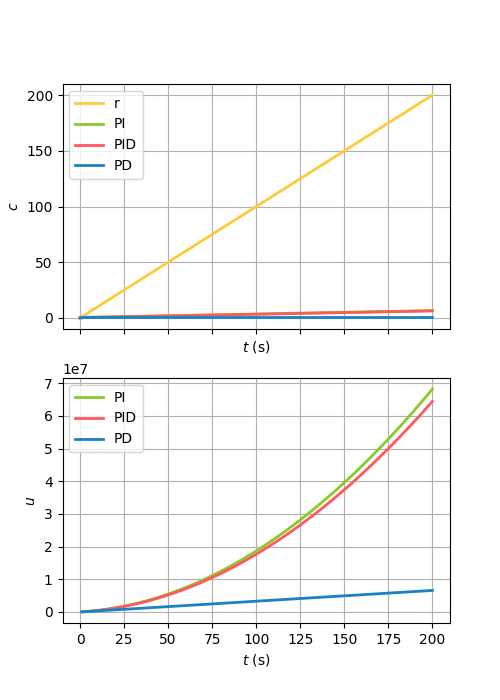

In [ ]:
# simulação do sistema em MF
ts = np.linspace(0, 200, 2000)

t, y_PI = ct.forced_response(rc_tf_PI, ts, U=ts)
t, u_PI = ct.forced_response(ru_tf_PI, ts, U=ts)

t, y_PID = ct.forced_response(rc_tf_PID, ts, U=ts)
t, u_PID = ct.forced_response(ru_tf_PID, ts, U=ts)

t, y_PD = ct.forced_response(rc_tf_PD, ts, U=ts)
t, u_PD = ct.forced_response(ru_tf_PD, ts, U=ts)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

state.plot(t, t, color=cp['yellow'], label='r', linewidth=2)
state.plot(t, y_PI, color=cp['green'], label='PI', linewidth=2)
state.plot(t, y_PID, color=cp['red'], label='PID', linewidth=2)
state.plot(t, y_PD, color=cp['blue'], label='PD', linewidth=2)
state.set_ylabel(r'$c$')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()

control_input.plot(t[10:], u_PI[10:], color=cp['green'],
                   label='PI', linewidth=2)
control_input.plot(t[10:], u_PID[10:], color=cp['red'],
                   label='PID', linewidth=2)
control_input.plot(t[10:], u_PD[10:], color=cp['blue'],
                   label='PD', linewidth=2)
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()

c:\Users\Eduardo\anaconda3\envs\control_env\lib\site-packages\control\timeresp.py:946: UserWarning: Non-zero initial condition given for transfer function system. Internal conversion to state space used; may not be consistent with given X0.
  warnings.warn(


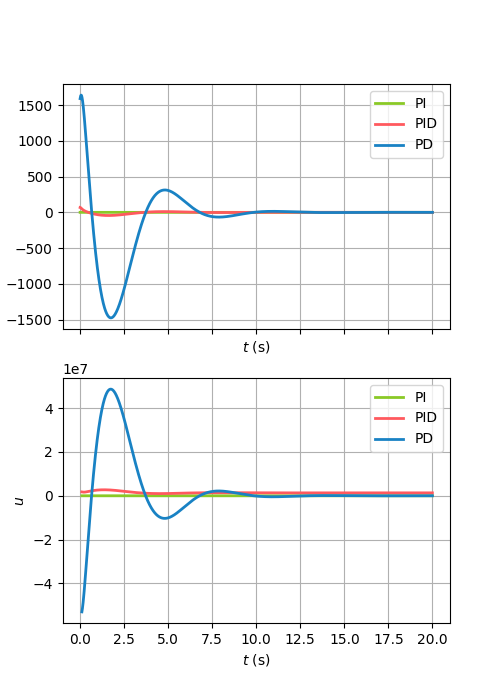

In [ ]:
# simulação do sistema em MF
ts = np.linspace(0, 20, 2000)
x0 = 0.0001

t, y_PI = ct.forced_response(rc_tf_PI, T=ts, U=0, X0 = x0)
t, u_PI = ct.forced_response(ru_tf_PI, T=ts, U=0, X0 = x0)

t, y_PID = ct.forced_response(rc_tf_PID, T=ts, U=0, X0 = x0)
t, u_PID = ct.forced_response(ru_tf_PID, T=ts, U=0, X0 = x0)

t, y_PD = ct.forced_response(rc_tf_PD, T=ts, U=0, X0 = x0)
t, u_PD = ct.forced_response(ru_tf_PD, T=ts, U=0, X0 = x0)

fig, (state, control_input) = plt.subplots(
    2, 1, figsize=(5, 7), sharex=True)

#state.plot(t, t, color=cp['yellow'], label='r', linewidth=2)
state.plot(t, y_PI, color=cp['green'], label='PI', linewidth=2)
state.plot(t, y_PID, color=cp['red'], label='PID', linewidth=2)
state.plot(t, y_PD, color=cp['blue'], label='PD', linewidth=2)
state.set_ylabel(r'$c$')
state.set_xlabel(r'$t$ (s)')
state.legend()
state.grid()

control_input.plot(t[10:], u_PI[10:], color=cp['green'],
                   label='PI', linewidth=2)
control_input.plot(t[10:], u_PID[10:], color=cp['red'],
                   label='PID', linewidth=2)
control_input.plot(t[10:], u_PD[10:], color=cp['blue'],
                   label='PD', linewidth=2)
control_input.set_ylabel(r'$u$')
control_input.set_xlabel(r'$t$ (s)')
control_input.legend()
control_input.grid()